# Lending Decisioning Sandbox — Amount / Term / Pricing / Fees → Expected NPV Profit
**Colab-ready mini-case (simulation layer on top of PD)**

This notebook is a *product + risk decisioning* mini-case that complements the **Give Me Some Credit** PD modeling project.

## What this tests
For each applicant we:
1) estimate **PD** (probability of default) using an interpretable baseline (**Logistic Regression + calibration**) on `cs-training.csv`  
2) evaluate a grid of **offers**: loan **amount**, **term**, **APR**, **origination fee**  
3) choose the offer that maximizes **expected NPV profit** under **risk appetite constraints** (e.g., bad rate cap, affordability cap)  
4) compare **Champion vs Challenger** policies and report trade-offs (profit vs approval vs risk)

> **Note:** Product economics (LGD, cost of funds, fees, take-rate model) are **assumptions** because public datasets lack true cashflows and recoveries. The value is in showing a *repeatable decisioning framework* and *champion–challenger experimentation*.


## 0) Setup
Upload `cs-training.csv` into Colab (Files → Upload).


In [1]:
# If needed (usually preinstalled in Colab):
# !pip -q install numpy pandas scikit-learn matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, roc_curve

np.random.seed(42)


## 1) Load data + split (no leakage)

In [2]:
DATA_PATH = "cs-training.csv"
TARGET = "SeriousDlqin2yrs"

df = pd.read_csv(DATA_PATH, index_col=0)
y = df[TARGET].astype(int)
X = df.drop(columns=[TARGET])

print("Dataset shape:", df.shape)
print("Base rate:", y.mean())

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train/Valid/Test:", X_train.shape, X_valid.shape, X_test.shape)


Dataset shape: (150000, 11)
Base rate: 0.06684
Train/Valid/Test: (90000, 10) (30000, 10) (30000, 10)


## 2) Safe preprocessing (train-only) + risk-style flags

In [3]:
@dataclass
class PreprocParams:
    medians: pd.Series
    q_low: pd.Series
    q_high: pd.Series

def fit_preproc_params(X_train: pd.DataFrame, low_q=0.01, high_q=0.99) -> PreprocParams:
    med = X_train.median(numeric_only=True)
    ql = X_train.quantile(low_q, numeric_only=True)
    qh = X_train.quantile(high_q, numeric_only=True)
    return PreprocParams(medians=med, q_low=ql, q_high=qh)

def apply_preproc(X: pd.DataFrame, params: PreprocParams) -> pd.DataFrame:
    Xp = X.copy()

    for col in ["MonthlyIncome", "NumberOfDependents"]:
        if col in Xp.columns:
            Xp[f"{col}_missing"] = Xp[col].isna().astype(int)

    delin_cols = [
        "NumberOfTime30-59DaysPastDueNotWorse",
        "NumberOfTime60-89DaysPastDueNotWorse",
        "NumberOfTimes90DaysLate",
    ]
    for col in delin_cols:
        if col in Xp.columns:
            Xp[f"{col}_gt0"] = (Xp[col].fillna(0) > 0).astype(int)
    if all(col in Xp.columns for col in delin_cols):
        Xp["any_delinquency"] = (
            (Xp[delin_cols[0]].fillna(0) > 0) |
            (Xp[delin_cols[1]].fillna(0) > 0) |
            (Xp[delin_cols[2]].fillna(0) > 0)
        ).astype(int)

    for col in params.medians.index:
        if col in Xp.columns:
            Xp[col] = Xp[col].fillna(params.medians[col])

    for col in params.q_low.index:
        if col in Xp.columns:
            Xp[col] = Xp[col].clip(params.q_low[col], params.q_high[col])

    return Xp

params = fit_preproc_params(X_train, 0.01, 0.99)
Xtr_pre = apply_preproc(X_train, params)
Xva_pre = apply_preproc(X_valid, params)
Xte_pre = apply_preproc(X_test,  params)

Xtr_pre.shape, Xte_pre.shape


((90000, 16), (30000, 16))

## 3) Baseline PD model + calibration (prefit)

In [4]:
logreg = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=3000, solver="lbfgs"))
])
logreg.fit(Xtr_pre, y_train)

p_valid = logreg.predict_proba(Xva_pre)[:, 1]
p_test  = logreg.predict_proba(Xte_pre)[:, 1]

def ks_stat(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    return float(np.max(np.abs(tpr - fpr)))

print("AUC valid:", roc_auc_score(y_valid, p_valid))
print("AUC test :", roc_auc_score(y_test,  p_test))
print("KS  valid:", ks_stat(y_valid, p_valid))
print("KS  test :", ks_stat(y_test,  p_test))

cal_model = CalibratedClassifierCV(logreg, method="sigmoid", cv="prefit")
cal_model.fit(Xva_pre, y_valid)

p_test_cal  = cal_model.predict_proba(Xte_pre)[:, 1]
p_train_cal = cal_model.predict_proba(Xtr_pre)[:, 1]

print("AUC test (cal):", roc_auc_score(y_test, p_test_cal))
print("KS  test (cal):", ks_stat(y_test,  p_test_cal))


AUC valid: 0.8590372256534944
AUC test : 0.8596128628241861
KS  valid: 0.5688352791890607
KS  test : 0.5595922677678015


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


AUC test (cal): 0.8596128628241861
KS  test (cal): 0.5595922677678015


## 4) Lending economics + decisioning optimizer
We define a simplified expected NPV model and optimize offer terms per applicant.


In [5]:
# --- Economics / behavior parameters (tune these) ---
cost_of_funds_apr = 0.12
LGD = 0.70
orig_cost = 3.0
serv_cost_m = 0.30

# Take-rate model
take_beta0 = 2.0
take_beta_apr = 3.5
take_beta_fee = 8.0
take_beta_pd  = 1.0

# PD adjustment by offer terms (modest)
alpha_amt = 0.25
alpha_term = 0.20
alpha_burden = 2.0
alpha_apr = 0.20

# Constraints
PD_MAX = 0.25
MAX_BURDEN = 0.40
MIN_TAKE = 0.05


In [6]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def logit(p, eps=1e-6):
    p = np.clip(p, eps, 1-eps)
    return np.log(p / (1-p))

def annuity_payment(A, apr, T):
    r_m = apr / 12.0
    if abs(r_m) < 1e-9:
        return A / T
    return A * (r_m * (1 + r_m) ** T) / ((1 + r_m) ** T - 1)

def balance_after_k_payments(A, apr, T, k):
    r_m = apr / 12.0
    pmt = annuity_payment(A, apr, T)
    if abs(r_m) < 1e-9:
        return max(A - pmt * k, 0.0)
    return A * (1 + r_m) ** k - pmt * (((1 + r_m) ** k - 1) / r_m)

def expected_default_month(T, PD_offer):
    frac = 0.2 + 0.6 * (1 - PD_offer)
    d = int(np.clip(np.round(T * frac), 1, T))
    return d

def take_rate(apr, fee_rate, PD_offer):
    x = take_beta0 - take_beta_apr * apr - take_beta_fee * fee_rate - take_beta_pd * PD_offer
    return float(np.clip(sigmoid(x), 0.0, 1.0))

def pd_adjusted(pd_base, A, T, apr, income):
    pmt = annuity_payment(A, apr, T)
    income_safe = max(income, 1.0)
    burden = pmt / income_safe

    adj = (
        logit(pd_base)
        + alpha_amt * np.log(max(A, 1.0) / 150.0)
        + alpha_term * ((T - 6) / 6.0)
        + alpha_burden * (burden - 0.15)
        + alpha_apr * (apr - 0.30)
    )
    pd_off = float(np.clip(sigmoid(adj), 0.0005, 0.999))
    return pd_off, burden, pmt

def npv_good(A, T, apr, fee_rate):
    fee = fee_rate * A
    r_disc = cost_of_funds_apr / 12.0
    pmt = annuity_payment(A, apr, T)

    npv = (-A + fee - orig_cost)
    for t in range(1, T + 1):
        npv += (pmt - serv_cost_m) / ((1 + r_disc) ** t)
    return float(npv)

def npv_bad(A, T, apr, fee_rate, d):
    fee = fee_rate * A
    r_disc = cost_of_funds_apr / 12.0
    pmt = annuity_payment(A, apr, T)

    npv = (-A + fee - orig_cost)
    for t in range(1, d + 1):
        npv += (pmt - serv_cost_m) / ((1 + r_disc) ** t)

    B = balance_after_k_payments(A, apr, T, d)
    recovery = (1 - LGD) * B
    npv += recovery / ((1 + r_disc) ** d)
    return float(npv)


### Offer grid

In [7]:
amount_grid = [100, 150, 200, 250]
term_grid   = [3, 6, 9, 12]
apr_grid    = [0.25, 0.35, 0.45]
fee_grid    = [0.00, 0.03, 0.05]

offers = [(A, T, apr, fee) for A in amount_grid for T in term_grid for apr in apr_grid for fee in fee_grid]
len(offers)


144

### Optimize offers on the test population (Challenger)

In [8]:
pd_base = p_test_cal.copy()
income_arr = Xte_pre["MonthlyIncome"].values if "MonthlyIncome" in Xte_pre.columns else np.full(len(pd_base), 5000.0)

best_profit = np.full(len(pd_base), -1e18)
best_idx = np.full(len(pd_base), -1, dtype=int)
best_pd = np.full(len(pd_base), np.nan)
best_take = np.zeros(len(pd_base))
best_burden = np.full(len(pd_base), np.nan)

for j, (A, T, apr, fee) in enumerate(offers):
    # vectorize across applicants with Python loop (fast enough for test size)
    npv_g = npv_good(A, T, apr, fee)
    for i, (p0, inc) in enumerate(zip(pd_base, income_arr)):
        pd_off, burden, _ = pd_adjusted(p0, A, T, apr, inc)
        if pd_off > PD_MAX or burden > MAX_BURDEN:
            continue
        tr = take_rate(apr, fee, pd_off)
        if tr < MIN_TAKE:
            continue
        d = expected_default_month(T, pd_off)
        npv_b = npv_bad(A, T, apr, fee, d)
        exp_npv = (1 - pd_off) * npv_g + pd_off * npv_b
        exp_profit = tr * exp_npv
        if exp_profit > best_profit[i]:
            best_profit[i] = exp_profit
            best_idx[i] = j
            best_pd[i] = pd_off
            best_take[i] = tr
            best_burden[i] = burden

offered = (best_idx >= 0) & (best_profit > 0)
booking_prob = np.where(offered, best_take, 0.0)

print("Offer rate:", offered.mean())
print("Expected booking rate:", booking_prob.mean())
print("Expected profit per applicant:", best_profit.mean())


Offer rate: 0.9395333333333333
Expected booking rate: 0.4648050958278071
Expected profit per applicant: -5.853333333333331e+16


## 5) Champion vs Challenger comparison + visuals

In [9]:
def weighted_mean(x, w):
    wsum = np.sum(w)
    if wsum <= 0:
        return np.nan
    return float(np.sum(x * w) / wsum)

# Challenger metrics
A_best = np.where(offered, np.array([offers[k][0] for k in best_idx]), 0.0)
T_best = np.where(offered, np.array([offers[k][1] for k in best_idx]), np.nan)
APR_best = np.where(offered, np.array([offers[k][2] for k in best_idx]), np.nan)
F_best = np.where(offered, np.array([offers[k][3] for k in best_idx]), np.nan)

chall = {
    "offer_rate": float(offered.mean()),
    "booking_rate": float(booking_prob.mean()),
    "exp_profit_per_applicant": float(best_profit.mean()),
    "exp_bad_rate_booked": weighted_mean(best_pd[offered], booking_prob[offered]),
    "exp_loss_per_applicant": float(np.mean(booking_prob * best_pd * LGD * A_best)),
    "avg_amount_offered": float(np.nanmean(np.where(offered, A_best, np.nan))),
    "avg_term_offered": float(np.nanmean(np.where(offered, T_best, np.nan))),
    "avg_apr_offered": float(np.nanmean(np.where(offered, APR_best, np.nan))),
    "avg_fee_rate_offered": float(np.nanmean(np.where(offered, F_best, np.nan))),
}

# Champion policy
champ_A, champ_T, champ_apr, champ_fee = 150.0, 6, 0.35, 0.03
champ_PD_MAX = 0.08

profit_c = np.zeros(len(pd_base))
book_c = np.zeros(len(pd_base))
pd_c = np.zeros(len(pd_base))

npv_g_c = npv_good(champ_A, champ_T, champ_apr, champ_fee)

for i, (p0, inc) in enumerate(zip(pd_base, income_arr)):
    if p0 > champ_PD_MAX:
        continue
    pd_off, burden, _ = pd_adjusted(p0, champ_A, champ_T, champ_apr, inc)
    if burden > MAX_BURDEN:
        continue
    tr = take_rate(champ_apr, champ_fee, pd_off)
    if tr < MIN_TAKE:
        continue
    d = expected_default_month(champ_T, pd_off)
    npv_b_c = npv_bad(champ_A, champ_T, champ_apr, champ_fee, d)
    exp_npv = (1 - pd_off) * npv_g_c + pd_off * npv_b_c
    profit_c[i] = tr * exp_npv
    book_c[i] = tr
    pd_c[i] = pd_off

champ = {
    "offer_rate": float((profit_c > 0).mean()),
    "booking_rate": float(np.mean(book_c)),
    "exp_profit_per_applicant": float(np.mean(profit_c)),
    "exp_bad_rate_booked": weighted_mean(pd_c[profit_c > 0], book_c[profit_c > 0]),
    "exp_loss_per_applicant": float(np.mean(book_c * pd_c * LGD * champ_A)),
    "avg_amount_offered": champ_A,
    "avg_term_offered": champ_T,
    "avg_apr_offered": champ_apr,
    "avg_fee_rate_offered": champ_fee,
}

report = pd.DataFrame([champ, chall], index=["Champion", "Challenger"])
report


,offer_rate,booking_rate,exp_profit_per_applicant,exp_bad_rate_booked,exp_loss_per_applicant,avg_amount_offered,avg_term_offered,avg_apr_offered,avg_fee_rate_offered
Champion,0.798933,0.500223,4.724013e+00,0.019321,1.014804,150.000000,6.000000,0.35000,0.03
Challenger,0.939533,0.464805,-5.853333e+16,0.045287,NaN,247.505854,11.862698,0.44983,0.05


Profit uplift (per applicant): -1.2390595172688008e+16


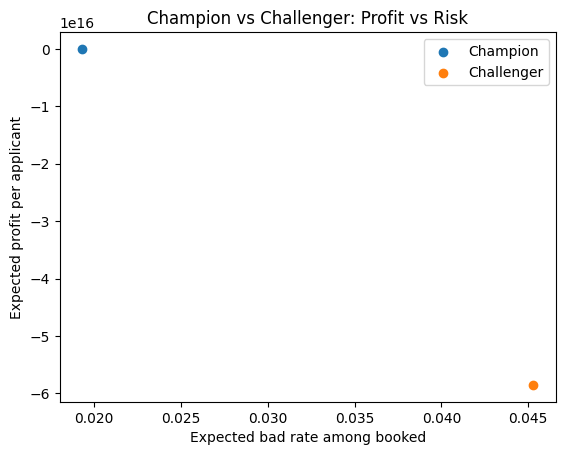

In [10]:
uplift = (chall["exp_profit_per_applicant"] / champ["exp_profit_per_applicant"] - 1.0) if champ["exp_profit_per_applicant"] != 0 else np.nan
print("Profit uplift (per applicant):", uplift)

plt.figure()
plt.scatter([champ["exp_bad_rate_booked"]], [champ["exp_profit_per_applicant"]])
plt.scatter([chall["exp_bad_rate_booked"]], [chall["exp_profit_per_applicant"]])
plt.xlabel("Expected bad rate among booked")
plt.ylabel("Expected profit per applicant")
plt.title("Champion vs Challenger: Profit vs Risk")
plt.legend(["Champion", "Challenger"])
plt.show()
